# Lab 8: Losses and Efficiency Analysis

#### Andrew Phillips

## Prelab: Preparing to Measure Efficiency and Losses

In this prelab, I started calculating the losses present in our lab hardware. These losses can be largely grouped into two categorie: conduction losses, which are resistive losses that are unavoidable when real components carry an electric current, and switching losses, which are largely caused by the semiconductor devices in our circuit changing operation regions and the parasitic capacitances present in the circuit constantly charging and discharging in the circuit. To start my investigation, I came up with a list of loss mechanisms I was aware of that I wanted to measure, broken into conduction and switching losses below:

(We are using clamp and high frequency snubber for this lab)
 
Conduction Losses:
- FET conduction losses (based on Rds on)
- Diode conduction losses
- Transformer conduction losses
- Shunt losses (minimal)
- Conduction losses related to snubber and clamp (predominant loss form, calculate average power from PLECS waveforms)

Switching Losses: 
- FET switching losses (From moving through the saturation region to the active region. Note on this: In DCM, we will only see loss at FET turn on)
- Diode switching losses (Note, turn on losses are small, but turn off is significant due to the reverse recovery effect. This is minimal in a Schottky)
- Switching losses from caps in circuit and clamp/snubber (minimal)
- Ringing loss

In [199]:
import csv
import pandas as pd

# read funky Rigol CSV format
def read_rigol_csv(csv_file_name):
    with open(csv_file_name) as f:
        rows = list(csv.reader(f))
        i = 0
        while rows[0][i] != "":
            i = i+1
        numcols = i-2
        t0 = float(rows[1][numcols])
        dT = float(rows[1][numcols+1])
    data = pd.read_csv(csv_file_name, usecols=range(0,numcols), skiprows=[1])
    data['X'] = t0+data['X']*dT
    return data, t0, dT

In [200]:
# import previous lab's data

# clamp
[l7_cl, l7_cl_t0, l7_cl_dT] = read_rigol_csv('data/lab_7_clamp.csv')

# apply data filter
l7_cl['CH1'] = l7_cl['CH1'].rolling(10).mean() # shunt voltage
l7_cl['CH2'] = l7_cl['CH2'].rolling(10).mean() # drain voltage
l7_cl['CH3'] = l7_cl['CH3'].rolling(10).mean() # cathode voltage

# remove NAN values from matricies
l7_cl_shunt = l7_cl['CH1'][500:5600]
l7_cl_drain = l7_cl['CH2'][500:5600]
l7_cl_time = l7_cl['X'][500:5600]

# convert shunt voltage to shunt current
Rshunt = 0.05 # Ohms
l7_cl_shunt = [x/(Rshunt*10) for x in l7_cl_shunt]
l7_cl_drain = [x+1-1 for x in l7_cl_drain]

'''
###
# zero out shunt ringing
for i,x in enumerate(l7_cl_shunt):
    if x < 0:
        l7_cl_shunt[i] = 0

for i in range(3200, len(l7_cl_shunt)):
    l7_cl_shunt[i] = 0

print(l7_cl_shunt)

# zero out negative drain values
for i,x in enumerate(l7_cl_drain):
    if x < 0:
        l7_cl_drain[i] = 0

print(l7_cl_drain)
'''


'\n###\n# zero out shunt ringing\nfor i,x in enumerate(l7_cl_shunt):\n    if x < 0:\n        l7_cl_shunt[i] = 0\n\nfor i in range(3200, len(l7_cl_shunt)):\n    l7_cl_shunt[i] = 0\n\nprint(l7_cl_shunt)\n\n# zero out negative drain values\nfor i,x in enumerate(l7_cl_drain):\n    if x < 0:\n        l7_cl_drain[i] = 0\n\nprint(l7_cl_drain)\n'

In [201]:
# Calculation block
from math import sqrt
import numpy as np

# Circuit parameters
# From worksheet
Vg = 18 # V
Vo = 10 # V
Pout = 20 # W
Fs = 50 # kHz
D = 0.35 # duty cycle

Rcp = 22 # Ohms, clamp resistance
Rsb_f = 10 # Ohms, fast snubber resistance

# From previous lab
Vpk_s = 4.28/10 # V, in shunt waveform from clamp testing in Lab 7

# baseline values
zeta_b = 0.041 # zeta baseline
L_b = 0.89e-6 # leakage
C_b = 6.5e-12 # capacitance

# From datasheets
Rds = 0.034 # Ohms
Vf = 0.68 # Forward voltage of diode

t_fall = 170e-9 #s
Vin = 30.8 #V

# From PLECS, using fundamental frequency of 50kHz
Irms_c = 0.4396 # clamp RMS current
Irms_s = 0.0434 # snubber RMS current
# Irms_shunt = 2.2403 # shunt RMS current

# Calculate RMS current primary
Ipk = Vpk_s/Rshunt 
print("Ipk from clamp testing",Ipk)
Irms = sqrt(D/3)*Ipk
print("I_rms in A:",Irms) # very large

# calculate transformer primary winding resistance
Rw = (2*zeta_b)/sqrt(C_b/L_b)
print("Primary winding resistance:",Rw)

# Conduction losses
FET_c = Rds*Irms**2
print("FET conduction losses:",FET_c)

D_c = Vf*Irms
print("Diode Conduction losses:",D_c)

# Tran_c = Rw*Irms_shunt**2
# print("Transformer conduction losses:",Tran_c)
# ^ This equation isn't useful because the transformer is only 
# causing conduction loss when it is ringing, which is only a
# very small amount of the waveform

Clamp_c = Irms_c**2*Rcp
print("Clamp conduction losses:",Clamp_c)

Snubber_c = Irms_s**2*Rsb_f
print("Snubber conduction losses:",Snubber_c)

Shunt_c = Irms**2*Rshunt
print("Shunt conduction losses:",Shunt_c)

# Switching losses
# FET switching losses: drain voltage * shunt current
# FET_s_list = np.multiply(l7_cl_drain,l7_cl_shunt)
# FET_s = sum(FET_s_list)

FET_s = 0.5*Vin*Ipk*t_fall*Fs # we only have turn off losses because we are running in DCM
print("FET switching losses:",FET_s)

# Diode switching losses:
# wait we use a schottky so what (Elvis said it should be minimal)

Ipk from clamp testing 8.56
I_rms in A: 2.9237966185538053
Primary winding resistance: 30.342557064802058
FET conduction losses: 0.2906519466666667
Diode Conduction losses: 1.9881817006165878
Clamp conduction losses: 4.25145952
Snubber conduction losses: 0.0188356
Shunt conduction losses: 0.4274293333333334
FET switching losses: 0.001120504


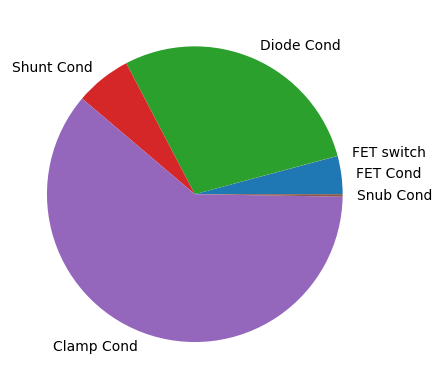

In [202]:
# Plot in pie chart
import matplotlib.pyplot as plt

losses = np.array([FET_c,FET_s,D_c,Shunt_c,Clamp_c,Snubber_c,])
labels = ["FET Cond","FET switch","Diode Cond","Shunt Cond","Clamp Cond","Snub Cond"]
plt.pie(losses,labels=labels)
plt.show()

## Data Collection

To collect the data

In [203]:
# efficiency calc
# task 1:
Rload = 5 #Ohms

Vg = 18 #V
Vo = 10 #V
Iin = 1.66 #A
Iout = Vo/Rload #A

Pin = Vg*Iin
print("Input power:",Pin)
Pout = Vo*Iout
print("Output Power:",Pout)

Eff_1 = Pout/Pin
print("Efficiency:",Eff_1)

Plost = Pin-Pout
print("Total power lost:",Plost)

# task 2:
Vg_2 = 17.26 #V
Vo_2 = 9.9 #V
Iin_2 = 1.7 #A
Iout_2 = Vo_2/Rload

Pin_2 = Vg_2*Iin_2
print("Input power:",Pin_2)
Pout_2 = Vo_2*Iout_2
print("Output Power:",Pout_2)

Eff_2 = Pout_2/Pin_2
print("Efficiency:",Eff_2)

Plost_2 = Pin_2-Pout_2
print("Total power lost:",Plost_2)

Input power: 29.88
Output Power: 20.0
Efficiency: 0.6693440428380187
Total power lost: 9.879999999999999
Input power: 29.342000000000002
Output Power: 19.602
Efficiency: 0.6680526208165769
Total power lost: 9.740000000000002


Task 2 BCM values:

Input : 17.26V, 1.7A
Output: 9.9V